In [22]:
import sys, os
import requests
import selenium
from selenium import webdriver
import requests
from pandas import DataFrame
from bs4 import BeautifulSoup
import re
from datetime import datetime
import pickle, progressbar, json, glob, time
from tqdm import tqdm

###### 날짜 저장 ##########
date = str(datetime.now())
date = date[:date.rfind(':')].replace(' ', '_')
date = date.replace(':','시') + '분'

sleep_sec = 0.5


####### 언론사별 본문 위치 태그 파싱 함수 ###########
print('본문 크롤링에 필요한 함수를 로딩하고 있습니다...\n' + '-' * 100)
def crawling_main_text(url):

    req = requests.get(url)
    req.encoding = None
    soup = BeautifulSoup(req.text, 'html.parser')
    
    # 연합뉴스 X
    if ('://yna' in url) | ('app.yonhapnews' in url): 
        main_article = soup.find('div', {'class':'story-news article'})
        if main_article == None:
            main_article = soup.find('div', {'class' : 'article-txt'})
            
        text = main_article.text
        
    # MBC X
    elif '//imnews.imbc' in url: 
        text = soup.find('div', {'itemprop' : 'articleBody'}).text
        
    # 매일경제(미라클), req.encoding = None 설정 필요
    elif 'mirakle.mk' in url:
        text = soup.find('div', {'class' : 'view_txt'}).text
        
    # 매일경제, req.encoding = None 설정 필요
    elif 'mk.co' in url:
        text = soup.find('div', {'class' : 'art_txt'}).text
        
    # SBS
    elif 'news.sbs' in url:
        text = soup.find('div', {'itemprop' : 'articleBody'}).text
    
    # KBS
    elif 'news.kbs' in url:
        text = soup.find('div', {'id' : 'cont_newstext'}).text
        
    # JTBC
    elif 'news.jtbc' in url:
        text = soup.find('div', {'class' : 'article_content'}).text
        
    # 그 외 X
    else:
        text == None
        
    return text.replace('\n','').replace('\r','').replace('<br>','').replace('\t','')
    
    
press_nm = 'KBS'

print('검색할 언론사 : {}'.format(press_nm))


############### 브라우저를 켜고 검색 키워드 입력 ####################
query = input('검색할 키워드  : ')
news_num = int(input('수집 뉴스의 수(숫자만 입력) : '))

print('\n' + '=' * 100 + '\n')

print('브라우저를 실행시킵니다(자동 제어)\n')
#chrome_path = 'C:/chromedriver/chromedriver.exe'
browser = webdriver.Chrome('./chromedriver_win32 (1)/chromedriver.exe')
#browser = webdriver.Chrome(chrome_path)

news_url = 'https://search.naver.com/search.naver?where=news&query={}'.format(query)
browser.get(news_url)
time.sleep(sleep_sec)


######### 언론사 선택 및 confirm #####################
print('설정한 언론사를 선택합니다.\n')

search_opn_btn = browser.find_element_by_xpath('//a[@class="btn_option _search_option_open_btn"]')
search_opn_btn.click()
time.sleep(sleep_sec)

bx_press = browser.find_element_by_xpath('//div[@role="listbox" and @class="api_group_option_sort _search_option_detail_wrap"]//li[@class="bx press"]')

# 기준 두번 째(언론사 분류순) 클릭하고 오픈하기
press_tablist = bx_press.find_elements_by_xpath('.//div[@role="tablist" and @class="option"]/a')
press_tablist[1].click()
time.sleep(sleep_sec)

# 첫 번째 것(언론사 분류선택)
bx_group = bx_press.find_elements_by_xpath('.//div[@class="api_select_option type_group _category_select_layer"]/div[@class="select_wrap _root"]')[0]

press_kind_bx = bx_group.find_elements_by_xpath('.//div[@class="group_select _list_root"]')[0]
press_kind_btn_list = press_kind_bx.find_elements_by_xpath('.//ul[@role="tablist" and @class="lst_item _ul"]/li/a')


for press_kind_btn in press_kind_btn_list:
    
    # 언론사 종류를 순차적으로 클릭(좌측)
    press_kind_btn.click()
    time.sleep(sleep_sec)
    
    # 언론사선택(우측)
    press_slct_bx = bx_group.find_elements_by_xpath('.//div[@class="group_select _list_root"]')[1]
    # 언론사 선택할 수 있는 클릭 버튼
    press_slct_btn_list = press_slct_bx.find_elements_by_xpath('.//ul[@role="tablist" and @class="lst_item _ul"]/li/a')
    # 언론사 이름들 추출
    press_slct_btn_list_nm = [psl.text for psl in press_slct_btn_list]
    
    # 언론사 이름 : 언론사 클릭 버튼 인 딕셔너리 생성
    press_slct_btn_dict = dict(zip(press_slct_btn_list_nm, press_slct_btn_list))
    
    # 원하는 언론사가 해당 이름 안에 있는 경우
    # 1) 클릭하고
    # 2) 더이상 언론사분류선택 탐색 중지
    if press_nm in press_slct_btn_dict.keys():
        print('<{}> 카테고리에서 <{}>를 찾았으므로 탐색을 종료합니다'.format(press_kind_btn.text, press_nm))
        
        press_slct_btn_dict[press_nm].click()
        time.sleep(sleep_sec)
        
        break



################ 뉴스 크롤링 ########################

print('\n크롤링을 시작합니다.')
# ####동적 제어로 페이지 넘어가며 크롤링
news_dict = {}
idx = 1
cur_page = 1

pbar = tqdm(total=news_num ,leave = True)
    
while idx < news_num:

    table = browser.find_element_by_xpath('//ul[@class="list_news"]')
    li_list = table.find_elements_by_xpath('./li[contains(@id, "sp_nws")]')
    area_list = [li.find_element_by_xpath('.//div[@class="news_area"]') for li in li_list]
    a_list = [area.find_element_by_xpath('.//a[@class="news_tit"]') for area in area_list]
 
    for n in a_list[:min(len(a_list), news_num-idx+1)]:
        n_url = n.get_attribute('href')
        news_dict[idx] = {'title' : n.get_attribute('title'), 
                          'url' : n_url,
                          'text' : crawling_main_text(n_url)}
        
        idx += 1
        pbar.update(1)
        
    if idx < news_num:
        cur_page +=1

        pages = browser.find_element_by_xpath('//div[@class="sc_page_inner"]')
        next_page_url = [p for p in pages.find_elements_by_xpath('.//a') if p.text == str(cur_page)][0].get_attribute('href')

        browser.get(next_page_url)
        time.sleep(sleep_sec)
    else:
        pbar.close()
        
        print('\n브라우저를 종료합니다.\n' + '=' * 100)
        time.sleep(0.7)
        browser.close()
        break

#### 데이터 전처리하기 ###################################################### 

print('데이터프레임 변환\n')
news_df = DataFrame(news_dict).T

folder_path = os.getcwd()
xlsx_file_name = '네이버뉴스_본문_{}개_{}_{}.xlsx'.format(news_num, query, date)

news_df.to_excel(xlsx_file_name)

print('엑셀 저장 완료 | 경로 : {}\\{}\n'.format(folder_path, xlsx_file_name))

os.startfile(folder_path)

print('=' * 100 + '\n결과물의 일부')
news_df

본문 크롤링에 필요한 함수를 로딩하고 있습니다...
----------------------------------------------------------------------------------------------------
검색할 언론사 : KBS
검색할 키워드  : 현금 없는 사회
수집 뉴스의 수(숫자만 입력) : 5


브라우저를 실행시킵니다(자동 제어)

설정한 언론사를 선택합니다.

<방송/통신> 카테고리에서 <KBS>를 찾았으므로 탐색을 종료합니다













  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


크롤링을 시작합니다.













 20%|████████████████▊                                                                   | 1/5 [00:01<00:07,  1.76s/it]










 40%|█████████████████████████████████▌                                                  | 2/5 [00:02<00:04,  1.44s/it]










 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:03<00:02,  1.22s/it]










 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:03<00:01,  1.08s/it]










100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]



브라우저를 종료합니다.
데이터프레임 변환

엑셀 저장 완료 | 경로 : C:\Users\상남\Farm\네이버뉴스_본문_5개_현금 없는 사회_2021-12-10_14시06분.xlsx

결과물의 일부


,title,url,text
1,"[주진우 라이브] 김재원 “김건희 일부 무혐의, 정권의 충견 노릇 하는 검찰도 없는...",https://news.kbs.co.kr/news/view.do?ncd=534402...,==============================================...
2,현금사용 급감…조폐공사 비화폐 사업 비중 확대,https://news.kbs.co.kr/news/view.do?ncd=523124...,[앵커] 코로나 사태 속에 대면을 최소화하는 모바일 뱅킹 등이 늘어난 대신 현금 ...
3,올해도 또 찾아온 김달봉 씨…꽁꽁 싸맨 비닐엔 1억2천만 원,https://news.kbs.co.kr/news/view.do?ncd=534229...,"[앵커] 어려운 이웃에 써달라며 해마다 고액을 기부하고 있는 이름 없는 천사, ..."
4,“어려운 이웃에 써달라”…김달봉 또 왔다,https://news.kbs.co.kr/news/view.do?ncd=534193...,"[앵커] 어려운 이웃에 써달라며 해마다 고액을 기부하고 있는 이름 없는 천사, ..."
5,법원 “삼례나라슈퍼 사건 수사한 검사에 중과실 있어”,https://news.kbs.co.kr/news/view.do?ncd=534032...,1999년 ‘삼례 나라슈퍼 사건’의 범인으로 몰려 억울한 옥살이를 한 뒤 재심에서 ...


In [2]:
!pip install progressbar

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12078 sha256=8eba3b3caca1843569b36012f8067d3c575c76cc92ba817a2d02de3e6808c8c6
  Stored in directory: c:\users\상남\appdata\local\pip\cache\wheels\2c\67\ed\d84123843c937d7e7f5ba88a270d11036473144143355e2747
Successfully built progressbar


In [25]:
import pandas as pd

In [27]:
df_KBS = pd.read_excel("KBS.xlsx")
df_KBS

,Unnamed: 0,title,url,text
0,2,현금사용 급감…조폐공사 비화폐 사업 비중 확대,https://news.kbs.co.kr/news/view.do?ncd=523124...,[앵커] 코로나 사태 속에 대면을 최소화하는 모바일 뱅킹 등이 늘어난 대신 현금 ...
1,6,QR코드 찍으면 거스름돈 500원 내 계좌로…‘동전없는 사회’의 시작?,http://news.kbs.co.kr/news/view.do?ncd=5000064...,'삑' QR코드를 찍자 남은 잔돈이 내 은행 계좌로 바로 입금됩니다. 3천 원으로...
2,7,이미 현금없는 사회인데…중국 디지털화폐 추진 속내,http://news.kbs.co.kr/news/view.do?ncd=4437211...,[앵커] 중국 정부가 오늘부터 디지털화폐 시범 운용에 나섭니다. 코로나 사태로 위...
3,8,[글로벌 경제] “취약계층 소외 우려”…‘현금없는 사회’ 후퇴하나?,http://news.kbs.co.kr/news/view.do?ncd=4365853...,[앵커] 세계 경제 움직임 알아보는 시간이죠. <글로벌 경제> 조항리 아나운서와 ...
4,11,"中, 현금 없는 사회…ATM기 애물단지 전락",http://news.kbs.co.kr/news/view.do?ncd=3659465...,[앵커] 중국에서는 길거리 좌판에서 간식을 하나 사먹을 때도 전자 결제를 하는 ...
5,13,모바일로 노숙자에 기부?…‘현금 없는’ 사회의 미래,http://news.kbs.co.kr/news/view.do?ncd=3536194...,올해 인터넷 전문은행 2곳이 출범했다. 지난 4월 문을 연 케이뱅크가 100일 만에...
6,15,4월부터 ‘동전 없는 사회’…“15년 내 현금도 사라져”,http://news.kbs.co.kr/news/view.do?ncd=3444910...,머지않은 미래에 동전은 박물관에서나 보게 될지도 모른다. 현금을 가지고 다니는 사람...
7,16,마윈 “中 5년내 '현금 없는 사회”,http://news.kbs.co.kr/news/view.do?ncd=3456917...,중국 알리바바그룹의 마윈(馬雲) 회장이 5년 내 중국에 현금이 필요 없는 사회가 구...
8,18,中 ‘현금 없는 일주일’…모바일 결제 급증,http://news.kbs.co.kr/news/view.do?ncd=3529030...,<앵커 멘트> 현금을 쓰지않고 모바일 결제를 하면 엄청난 경품을 준다는 행사로 중...
9,19,4년 뒤면 현금이 사라진다고?…‘뉴노멀 시대’,http://news.kbs.co.kr/news/view.do?ncd=3270495...,"2020년, 불과 4년 뒤엔 현금 없이 모바일만으로 결제하고, 인공지능(AI)이 건..."


In [28]:
df_SBS = pd.read_excel("SBS.xlsx")
df_SBS

,Unnamed: 0,title,url,text
0,3,"[친절한 경제] ""종이돈은 받아봤자""…'현금 없는 사회' 명암",https://news.sbs.co.kr/news/endPage.do?news_id...,"<앵커> 권애리 기자의 친절한 경제 시작합니다. 권 기자, 오늘(7일)은 지..."
1,4,"스웨덴 '현금없는 사회'에서 궤도 수정…""ATM 줄자 폐해""",https://news.sbs.co.kr/news/endPage.do?news_id...,"'현금 없는 사회'로 진입한 국가에서 관련 부작용이 나타나고 있으며, 한국도 국..."
2,5,'현금 없는 사회' 문턱서 발행 10돌 맞은 5만 원권,https://news.sbs.co.kr/news/endPage.do?news_id...,23일로 발행 10주년을 맞은 5만원권은 어느새 다른 권종을 누르고 가장 많은 ...
3,6,"한은 ""비상시 현금은 가장 신뢰할 만한 수단…유통 계속돼야""",https://news.sbs.co.kr/news/endPage.do?news_id...,한국은행은 비상시 현금은 가장 신뢰할 만한 지급수단이며 비상사태에 대비해 현금을...
4,7,헌금도 '카드 결제'…현금 없는 사회의 모습,http://news.sbs.co.kr/news/endPage.do?news_id=...,"<앵커> 현금이 사라진다면 어떨까요? 불가능한, 먼 미래의 얘기가 아닙니다...."
5,8,[취재파일플러스] 교회 헌금도 카드로…'현금 없는 사회',http://news.sbs.co.kr/news/endPage.do?news_id=...,주말에 교회나 성당에서 헌금 하신 분들 많이 계시죠. 아무리 카드 사용이 늘었다...
6,9,"현금없는 세상, 범죄 줄지만…'빅 브라더' 우려",http://news.sbs.co.kr/news/endPage.do?news_id=...,<앵커> '현금 없는 사회'는 이제 세계적인 대세입니다. 현금 없이 살 수 ...
7,10,[취재파일] '동전' 2020년까지 사라진다…현금 없는 대한민국 '성큼',http://news.sbs.co.kr/news/endPage.do?news_id=...,요즘 젊은 회사원들의 지갑에서 현금을 찾아보기 쉽지 않습니다. 회사원 엄지애씨는...
8,11,"한은, 동전없는 사회 추진…공동연구그룹 구성",http://news.sbs.co.kr/news/endPage.do?news_id=...,한국은행이 '동전없는 사회'를 만들기 위한 본격적인 행보에 나섰습니다. 한은...
9,12,"""현금 필요성 못 느껴""…청소년도 '전자용돈'",http://news.sbs.co.kr/news/endPage.do?news_id=...,<앵커> 우리나라도 이런 현금 없는 사회가 성큼 다가왔습니다. 현금을 갖고 ...


In [29]:
df_JTBC = pd.read_excel("JTBC.xlsx")
df_JTBC

,Unnamed: 0,title,url,text
0,3,[일요플러스] 축의금도 스마트폰 터치…미리 가본 '현금없는 사회',http://news.jtbc.co.kr/html/866/NB11432866.html,[앵커]신용카드 정보를 스마트폰에 넣어서 지갑처...
1,4,2020년까지 '동전 없는 사회' 추진…어떤 변화 있나?,http://news.jtbc.co.kr/html/539/NB11166539.html,[앵커]동전을 불편해하시는 분들께는 반가운 소식...
2,5,[꼼꼼한 경제] '동전 없는 사회' 진짜 오나…어떤 모습?,http://news.jtbc.co.kr/html/116/NB11166116.html,[앵커]한국은행이 2020년까지 '동전 없는 사...


In [30]:
df_info = pd.DataFrame()
df_info = df_info.append(df_KBS,ignore_index = True)
df_info = df_info.append(df_SBS,ignore_index = True)
df_info = df_info.append(df_JTBC,ignore_index = True)
df_info

,Unnamed: 0,title,url,text
0,2,현금사용 급감…조폐공사 비화폐 사업 비중 확대,https://news.kbs.co.kr/news/view.do?ncd=523124...,[앵커] 코로나 사태 속에 대면을 최소화하는 모바일 뱅킹 등이 늘어난 대신 현금 ...
1,6,QR코드 찍으면 거스름돈 500원 내 계좌로…‘동전없는 사회’의 시작?,http://news.kbs.co.kr/news/view.do?ncd=5000064...,'삑' QR코드를 찍자 남은 잔돈이 내 은행 계좌로 바로 입금됩니다. 3천 원으로...
2,7,이미 현금없는 사회인데…중국 디지털화폐 추진 속내,http://news.kbs.co.kr/news/view.do?ncd=4437211...,[앵커] 중국 정부가 오늘부터 디지털화폐 시범 운용에 나섭니다. 코로나 사태로 위...
3,8,[글로벌 경제] “취약계층 소외 우려”…‘현금없는 사회’ 후퇴하나?,http://news.kbs.co.kr/news/view.do?ncd=4365853...,[앵커] 세계 경제 움직임 알아보는 시간이죠. <글로벌 경제> 조항리 아나운서와 ...
4,11,"中, 현금 없는 사회…ATM기 애물단지 전락",http://news.kbs.co.kr/news/view.do?ncd=3659465...,[앵커] 중국에서는 길거리 좌판에서 간식을 하나 사먹을 때도 전자 결제를 하는 ...
5,13,모바일로 노숙자에 기부?…‘현금 없는’ 사회의 미래,http://news.kbs.co.kr/news/view.do?ncd=3536194...,올해 인터넷 전문은행 2곳이 출범했다. 지난 4월 문을 연 케이뱅크가 100일 만에...
6,15,4월부터 ‘동전 없는 사회’…“15년 내 현금도 사라져”,http://news.kbs.co.kr/news/view.do?ncd=3444910...,머지않은 미래에 동전은 박물관에서나 보게 될지도 모른다. 현금을 가지고 다니는 사람...
7,16,마윈 “中 5년내 '현금 없는 사회”,http://news.kbs.co.kr/news/view.do?ncd=3456917...,중국 알리바바그룹의 마윈(馬雲) 회장이 5년 내 중국에 현금이 필요 없는 사회가 구...
8,18,中 ‘현금 없는 일주일’…모바일 결제 급증,http://news.kbs.co.kr/news/view.do?ncd=3529030...,<앵커 멘트> 현금을 쓰지않고 모바일 결제를 하면 엄청난 경품을 준다는 행사로 중...
9,19,4년 뒤면 현금이 사라진다고?…‘뉴노멀 시대’,http://news.kbs.co.kr/news/view.do?ncd=3270495...,"2020년, 불과 4년 뒤엔 현금 없이 모바일만으로 결제하고, 인공지능(AI)이 건..."


In [44]:
posts = df_info['title']
posts

0                    현금사용 급감…조폐공사 비화폐 사업 비중 확대
1      QR코드 찍으면 거스름돈 500원 내 계좌로…‘동전없는 사회’의 시작?
2                  이미 현금없는 사회인데…중국 디지털화폐 추진 속내
3        [글로벌 경제] “취약계층 소외 우려”…‘현금없는 사회’ 후퇴하나?
4                     中, 현금 없는 사회…ATM기 애물단지 전락
5                 모바일로 노숙자에 기부?…‘현금 없는’ 사회의 미래
6              4월부터 ‘동전 없는 사회’…“15년 내 현금도 사라져”
7                         마윈 “中 5년내 '현금 없는 사회”
8                      中 ‘현금 없는 일주일’…모바일 결제 급증
9                    4년 뒤면 현금이 사라진다고?…‘뉴노멀 시대’
10                        현금 사라지는 국가? 현실이 눈앞에…
11                     한국은행 ‘동전없는 사회’ 도입 방안 검토
12          [친절한 경제] "종이돈은 받아봤자"…'현금 없는 사회' 명암
13           스웨덴 '현금없는 사회'에서 궤도 수정…"ATM 줄자 폐해"
14              '현금 없는 사회' 문턱서 발행 10돌 맞은 5만 원권
15           한은 "비상시 현금은 가장 신뢰할 만한 수단…유통 계속돼야"
16                    헌금도 '카드 결제'…현금 없는 사회의 모습
17             [취재파일플러스] 교회 헌금도 카드로…'현금 없는 사회'
18                  현금없는 세상, 범죄 줄지만…'빅 브라더' 우려
19    [취재파일] '동전' 2020년까지 사라진다…현금 없는 대한민국 '성큼'
20                    한은, 동전없는 사회 추진…공동연구그룹 구성
21           

In [45]:
from eunjeon import Mecab
tagger = Mecab()

In [46]:
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
695,필요한
696,등을
697,해당하는
698,자가


In [47]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]

['현금', '사용', '급감', '조폐공사', '화폐', '사업', '비중', '확대', '코드', '거스름돈']

In [48]:
words = []
for post in posts:
    words.extend(tagger.pos(post))
words[0:10]

[('현금', 'NNG'),
 ('사용', 'NNG'),
 ('급감', 'NNG'),
 ('…', 'SE'),
 ('조폐공사', 'NNP'),
 ('비', 'XPN'),
 ('화폐', 'NNG'),
 ('사업', 'NNG'),
 ('비중', 'NNG'),
 ('확대', 'NNG')]

In [49]:
# 동사 추출
verbs=[]
for word in words:
    if word[1]=='VV':
        verbs.append(word[0]+'다')
verbs[0:10]

['찍다', '사라지다', '받다', '맞다', '줄다', '줄어드다', '오다']

In [50]:
# 형용사 추출
adjective=[]
for word in words:
    if word[1]=='VA':
        adjective.append(word[0]+'다')
adjective[0:10]

['없다', '없다', '없다', '없다', '없다', '없다', '없다', '없다', '없다', '없다']

In [51]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 200
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'현금': 21,
 '사회': 19,
 '동전': 9,
 '경제': 4,
 '내': 3,
 '추진': 3,
 '中': 3,
 '결제': 3,
 '도입': 3,
 '화폐': 2,
 '원': 2,
 '우려': 2,
 '모바일': 2,
 '방안': 2,
 '검토': 2,
 '친절': 2,
 '만': 2,
 '한': 2,
 '수단': 2,
 '헌금': 2,
 '카드': 2,
 '모습': 2,
 '취재': 2,
 '파일': 2,
 '플러스': 2,
 '사용': 1,
 '급감': 1,
 '조폐공사': 1,
 '사업': 1,
 '비중': 1,
 '확대': 1,
 '코드': 1,
 '거스름돈': 1,
 '계좌': 1,
 '시작': 1,
 '중국': 1,
 '디지털': 1,
 '속내': 1,
 '글로벌': 1,
 '취약': 1,
 '계층': 1,
 '소외': 1,
 '후퇴': 1,
 '기': 1,
 '애물단지': 1,
 '전락': 1,
 '노숙자': 1,
 '기부': 1,
 '미래': 1,
 '마윈': 1,
 '일주일': 1,
 '급증': 1,
 '뒤': 1,
 '뉴노': 1,
 '시대': 1,
 '국가': 1,
 '현실': 1,
 '눈앞': 1,
 '한국은행': 1,
 '종이돈': 1,
 '명암': 1,
 '스웨덴': 1,
 '궤도': 1,
 '수정': 1,
 '줄자': 1,
 '폐해': 1,
 '문턱': 1,
 '발행': 1,
 '돌': 1,
 '권': 1,
 '비상시': 1,
 '신뢰': 1,
 '유통': 1,
 '계속': 1,
 '교회': 1,
 '세상': 1,
 '범죄': 1,
 '빅': 1,
 '브라더': 1,
 '대한민국': 1,
 '공동': 1,
 '연구': 1,
 '그룹': 1,
 '구성': 1,
 '필요': 1,
 '청소년': 1,
 '용돈': 1,
 '월드리포트': 1,
 '이게': 1,
 '우문': 1,
 '愚問': 1,
 '나라': 1,
 '한은': 1,
 '개발': 1,
 '절반': 1,
 '수도': 1,
 '일요': 1,
 '축의금': 1,
 '스

In [52]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='C:/Users/상남/newlab/font/font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_nouns)

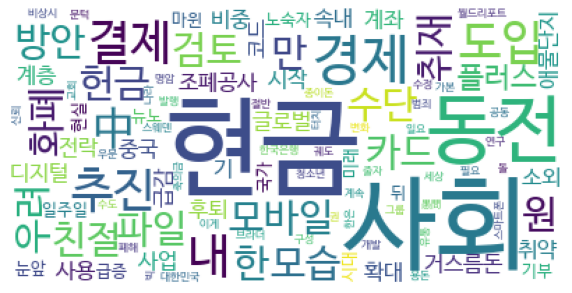

In [53]:
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)